### Prediction Scaling

In [1]:
import torch
import utils.classification_dataset

# id_preds = torch.load('id_preds.pt')
id_logits = torch.load('id_logits.pt', map_location=torch.device('cpu'))
ood_logits = torch.load('ood_logits.pt', map_location=torch.device('cpu'))
map_preds = torch.load('MAP_preds.pt', map_location=torch.device('cpu'))
map_preds_ood = torch.load('MAP_preds.pt', map_location=torch.device('cpu'))
map_preds_logits = torch.load('MAP_preds_logits.pt', map_location=torch.device('cpu'))
map_preds_ood_logits = torch.load('MAP_preds_ood_logits.pt', map_location=torch.device('cpu'))

dataset = utils.classification_dataset.load_dataset('fmnist', False)

test_targets = torch.cat([y for _,y in dataset.testloader(100)])

In [83]:
import utils.metrics as um
from importlib import reload
reload(um)

test_loader = dataset.testloader(1000)
tolerance_acc_dict = {}



# CUQLS
scale = 10
acc_conf, _ = um.tolerance_acc((id_logits * scale).softmax(-1), test_loader)
tolerance_acc_dict['CUQLS'] = {'conf': acc_conf,
                               'var': acc_var}

# MAP
acc_conf_map = um.tolerance_acc(map_preds, test_loader, deterministic=True)
tolerance_acc_dict['MAP'] = {'conf': acc_conf_map}

In [10]:
def predictions_tolerance(preds, targets, tau, var=None, deterministic=False):
    # Confidence tolerance
    if deterministic:
        conf = preds.max(-1)[0]
        conf_pred = preds[conf >= tau,:]
    else:
        conf = preds.mean(0).max(-1)[0]
        conf_pred = preds[:,conf >= tau,:]

    conf_targets = targets[conf >= tau]

    if not deterministic:
        # var = preds.var(0).sum(-1); 
        vm = var.max()
        # Var tolerance
        var_pred = preds[var < vm*(1-tau),:]
        var_targets = targets[var < vm*(1-tau)]

        return conf_pred, conf_targets, var_pred, var_targets
    else:
        return conf_pred, conf_targets 

In [75]:
acc_var

[0.9341934323310852,
 0.9341868162155151,
 0.9341868162155151,
 0.9341868162155151,
 0.9341868162155151,
 0.9341868162155151,
 0.9341802597045898,
 0.9342737197875977,
 0.9342737197875977,
 0.9342737197875977,
 0.9342671632766724,
 0.9342671632766724,
 0.9342671632766724,
 0.9342671632766724,
 0.9342671632766724,
 0.9343540668487549,
 0.9344475865364075,
 0.9344475865364075,
 0.9344409704208374,
 0.9344409704208374,
 0.9349894523620605,
 0.93498295545578,
 0.9350766539573669,
 0.9350766539573669,
 0.9350701570510864,
 0.9350376129150391,
 0.9350376129150391,
 0.9350310564041138,
 0.9352121353149414,
 0.9352121353149414,
 0.9353932738304138,
 0.9353867769241333,
 0.9353802800178528,
 0.9353737831115723,
 0.9353737831115723,
 0.9358084201812744,
 0.9359710216522217,
 0.9360523819923401,
 0.936140239238739,
 0.936140239238739,
 0.9367932081222534,
 0.9367740750312805,
 0.9368622899055481,
 0.9368495345115662,
 0.9368431568145752,
 0.9381464123725891,
 0.9382352828979492,
 0.93823528289794

In [81]:
var = id_logits.softmax(-1).var(0).sum(-1)
vm = var.max()

def map_var_tau(map_preds, targets, var, tau):
    vm = var.max()
    threshold = (1-tau)*vm
    return (map_preds[var < threshold].argmax(-1) == targets[var < threshold]).type(torch.float).mean().item()

print(map_var_tau(map_preds, targets, var, 0.9))

tau_range = torch.linspace(0,1,100)
acc_var = []
for tau in tau_range:
    acc_var.append(map_var_tau(map_preds, targets, var, tau))

0.9760735630989075


In [82]:
acc_var

[0.9341934323310852,
 0.9341868162155151,
 0.9341868162155151,
 0.9341802597045898,
 0.9342737197875977,
 0.9342671632766724,
 0.9342671632766724,
 0.9342671632766724,
 0.9344475865364075,
 0.9344409704208374,
 0.9349894523620605,
 0.9350766539573669,
 0.9350701570510864,
 0.9350376129150391,
 0.9352121353149414,
 0.9353932738304138,
 0.9353802800178528,
 0.9353737831115723,
 0.9359710216522217,
 0.936140239238739,
 0.9367932081222534,
 0.9368622899055481,
 0.9368431568145752,
 0.9382352828979492,
 0.9384194016456604,
 0.9384896755218506,
 0.9387630820274353,
 0.9388521909713745,
 0.9409058094024658,
 0.9410681128501892,
 0.9419367909431458,
 0.9422208666801453,
 0.9423116445541382,
 0.943985104560852,
 0.9440306425094604,
 0.9442259669303894,
 0.9442890882492065,
 0.9443696141242981,
 0.9456748962402344,
 0.9456635117530823,
 0.9497979283332825,
 0.9502344131469727,
 0.9504052996635437,
 0.9515053629875183,
 0.9520732164382935,
 0.9522629380226135,
 0.9522629380226135,
 0.952350139617

In [77]:
targets = torch.cat([y for _,y in test_loader])

tau_range = torch.linspace(0,1,100)
acc_conf = []
acc_var = []

for tau in tau_range:
    pred_target = predictions_tolerance(map_preds, targets, tau, var=(id_logits).softmax(-1).var(0).sum(-1))
    # conf_pred, conf_targets, var_pred, var_targets = predictions_tolerance(preds, targets, tau)
    conf_pred, conf_targets, var_pred, var_targets = pred_target 
    # acc_conf.append((conf_pred.mean(0).argmax(-1) == conf_targets).type(torch.float).mean().item())
    acc_var.append((var_pred.mean(0).argmax(-1) == var_targets).type(torch.float).mean().item())

In [13]:
pred_target

(tensor([], size=(10000, 0, 10), dtype=torch.float64),
 tensor([], size=(0, 10000), dtype=torch.int64),
 tensor([[1.9055e-08, 1.9248e-08, 9.2713e-10,  ..., 1.4405e-09, 3.9774e-09,
          1.0000e+00],
         [3.3617e-05, 1.9678e-07, 9.9994e-01,  ..., 3.1073e-06, 8.0010e-07,
          3.4800e-07],
         [4.5799e-06, 9.9982e-01, 6.2717e-06,  ..., 3.4617e-06, 6.2394e-06,
          1.1820e-05],
         ...,
         [3.9662e-07, 1.1008e-07, 2.6175e-07,  ..., 3.8151e-09, 1.0000e+00,
          1.4178e-08],
         [9.8559e-08, 1.0000e+00, 3.0492e-07,  ..., 9.5128e-08, 1.3684e-08,
          1.1202e-07],
         [7.3176e-04, 1.0203e-06, 1.8364e-06,  ..., 1.0283e-02, 1.5777e-05,
          5.8007e-06]], dtype=torch.float64),
 tensor([9, 2, 1,  ..., 8, 1, 5]))

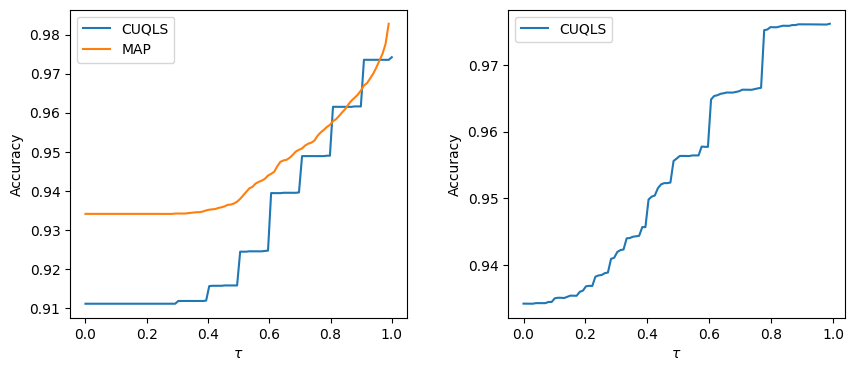

In [84]:
import matplotlib.pyplot as plt
import numpy as np

def tolerance_plot(acc_dict):
    f,(ax) = plt.subplots(1,2, figsize = (10,4))
    f.subplots_adjust(wspace=0.3)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel(r"$\tau$")

    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel(r"$\tau$")

    for m in acc_dict.keys():
        for idx,k in enumerate(acc_dict[m].keys()):
            acc = acc_dict[m][k]
            ax[idx].plot(np.linspace(0,1,len(acc)), acc, label=m)

    ax[0].legend()
    ax[1].legend()

    plt.show()

tolerance_plot(tolerance_acc_dict)

In [8]:
m = 'CUQLS'
test_res = {}
train_res = {}

test_res[m] = {'nll': [],
            'acc': [],
            'ece': [],
            'oodauc': [],
            'aucroc': [],
            'varroc': [],
            'varroc_id': [],
            'varroc_ood': [],
            'varroc_rot': [0],
            'time': [0],
            'mem': [0]}

train_res[m] = {'nll': [0],
                'acc': [0]}


In [10]:
scale_range = np.linspace(0.1,2,50)
# scale_range = [0.3]
for scale in scale_range:
    id_predictions = (id_logits * scale).softmax(-1)
    ood_predictions = (ood_logits * scale).softmax(-1)
    metrics_m = um.compute_metrics(test_loader, id_predictions, ood_predictions, samples=True)

    test_res[m]['nll'].append(metrics_m[0])
    test_res[m]['acc'].append(metrics_m[1])
    test_res[m]['ece'].append(metrics_m[2])
    test_res[m]['oodauc'].append(metrics_m[3])
    test_res[m]['aucroc'].append(metrics_m[4])
    test_res[m]['varroc'].append(metrics_m[5])
    test_res[m]['varroc_id'].append(metrics_m[6])
    test_res[m]['varroc_ood'].append(metrics_m[7])

    print(fr'$\gamma$ = {scale:.3f}')
    um.print_results(m, test_res, 0, train_res)

    test_res[m] = {'nll': [],
            'acc': [],
            'ece': [],
            'oodauc': [],
            'aucroc': [],
            'varroc': [],
            'varroc_id': [],
            'varroc_ood': [],
            'varroc_rot': [0],
            'time': [0],
            'mem': [0]}

$\gamma$ = 0.100

--- Method CUQLS ---
Train Results -- Loss: 0.000; Train Acc: 0.0%
Test Results -- Acc.: 98.9%; ECE: 25.9%; NLL: 0.336; OOD-AUC: 90.6%; AUC-ROC: 90.0%; VAR-ROC: 69.9%; VAR-ROC-ID: 69.9%; VAR-ROC-OOD: 70.1%; VARROC-ROT: 0.0%; Time h:m:s: 00:00:00

$\gamma$ = 0.139

--- Method CUQLS ---
Train Results -- Loss: 0.000; Train Acc: 0.0%
Test Results -- Acc.: 98.9%; ECE: 13.2%; NLL: 0.172; OOD-AUC: 90.0%; AUC-ROC: 89.3%; VAR-ROC: 82.8%; VAR-ROC-ID: 92.1%; VAR-ROC-OOD: 83.3%; VARROC-ROT: 0.0%; Time h:m:s: 00:00:00

$\gamma$ = 0.178

--- Method CUQLS ---
Train Results -- Loss: 0.000; Train Acc: 0.0%
Test Results -- Acc.: 98.9%; ECE: 7.1%; NLL: 0.102; OOD-AUC: 89.3%; AUC-ROC: 88.6%; VAR-ROC: 85.1%; VAR-ROC-ID: 96.4%; VAR-ROC-OOD: 85.6%; VARROC-ROT: 0.0%; Time h:m:s: 00:00:00

$\gamma$ = 0.216

--- Method CUQLS ---
Train Results -- Loss: 0.000; Train Acc: 0.0%
Test Results -- Acc.: 98.9%; ECE: 4.1%; NLL: 0.0687; OOD-AUC: 88.7%; AUC-ROC: 88.0%; VAR-ROC: 85.5%; VAR-ROC-ID: 97.3%; V

In [41]:
m = 'MAP'
test_res = {}
train_res = {}

test_res[m] = {'nll': [],
            'acc': [],
            'ece': [],
            'oodauc': [],
            'aucroc': [],
            'time': [0],
            'mem': [0]}

train_res[m] = {'nll': [0],
                'acc': [0]}


In [42]:
scale_range = np.linspace(0.1,2,50)
# scale_range = [0.3]
for scale in scale_range:
    id_predictions = (map_preds_logits * scale).softmax(-1)
    ood_predictions = (map_preds_ood_logits * scale).softmax(-1)
    metrics_m = um.compute_metrics(test_loader, id_predictions, ood_predictions, samples=False)

    test_res[m]['nll'].append(metrics_m[0])
    test_res[m]['acc'].append(metrics_m[1])
    test_res[m]['ece'].append(metrics_m[2])
    test_res[m]['oodauc'].append(metrics_m[3])
    test_res[m]['aucroc'].append(metrics_m[4])

    print(fr'$\gamma$ = {scale:.3f}')
    um.print_results(m, test_res, 0, train_res)

    test_res[m] = {'nll': [],
            'acc': [],
            'ece': [],
            'oodauc': [],
            'aucroc': [],
            'time': [0],
            'mem': [0]}

$\gamma$ = 0.100

--- Method MAP ---
Train Results -- Loss: 0.000; Train Acc: 0.0%
Test Results -- Acc.: 98.9%; ECE: 75.0%; NLL: 1.44; OOD-AUC: 80.0%; AUC-ROC: 89.5%; Time h:m:s: 00:00:00

$\gamma$ = 0.139

--- Method MAP ---
Train Results -- Loss: 0.000; Train Acc: 0.0%
Test Results -- Acc.: 98.9%; ECE: 67.3%; NLL: 1.17; OOD-AUC: 83.1%; AUC-ROC: 89.7%; Time h:m:s: 00:00:00

$\gamma$ = 0.178

--- Method MAP ---
Train Results -- Loss: 0.000; Train Acc: 0.0%
Test Results -- Acc.: 98.9%; ECE: 58.9%; NLL: 0.934; OOD-AUC: 85.4%; AUC-ROC: 89.8%; Time h:m:s: 00:00:00

$\gamma$ = 0.216

--- Method MAP ---
Train Results -- Loss: 0.000; Train Acc: 0.0%
Test Results -- Acc.: 98.9%; ECE: 50.1%; NLL: 0.739; OOD-AUC: 87.1%; AUC-ROC: 90.0%; Time h:m:s: 00:00:00

$\gamma$ = 0.255

--- Method MAP ---
Train Results -- Loss: 0.000; Train Acc: 0.0%
Test Results -- Acc.: 98.9%; ECE: 41.7%; NLL: 0.58; OOD-AUC: 88.2%; AUC-ROC: 90.0%; Time h:m:s: 00:00:00

$\gamma$ = 0.294

--- Method MAP ---
Train Results --

### Ternary

In [20]:
def ternary_search(f, left, right, its, verbose=False, input_name = 'input', output_name = 'function'):
    left_input, right_input = left, right

    # Ternary Search
    for _ in range(its):
        left_third = left_input + (right_input - left_input) / 3
        right_third = right_input - (right_input - left_input) / 3

        # Left function value
        left_f = f(left_third)

        # Right ECE
        right_f = f(right_third)

        if left_f > right_f:
            left_input = left_third
        else:
            right_input = right_third

        input = (left_input + right_input) / 2

        # Print info
        if verbose:
            print(f'\n{input_name}: {input:.3}; {output_name}: [{left_f:.1},{right_f:.1}]') 

        if abs(right_input - left_input) <= 1e-2:
            if verbose:
                print('Converged.')
            break

    return input

In [ ]:
def ece_eval(gamma):
    scaled_nuqls_predictions = val_predictions * gamma
    obs_map, predicted = utils.calibration_curve_r(val_y,val_predictions.mean(1),scaled_nuqls_predictions.var(1),11)
    return torch.mean(torch.square(obs_map - predicted)).item()

### Rotated-MNIST Result Method

In [15]:
import utils.datasets as ds
import utils.metrics as metrics

def rotated_dataset(id_predictions_probit, pred_func, dataset):
    '''
    Input:
        id_predictions_probit: predictions on MNIST test set, size S x N x C, in PROBIT space. 

        pred_func: (function) that takes dataset (torch.utils.data.Dataset), and outputs S x N x C in logits space, where
                    S is number of mc samples, N is len(dataset), and C is number of classes

        dataset: (str) in ['mnist','fmnist']

    Output:
        Averaged VARROC over all rotations of MNIST. Higher is better.
    
    '''
    if dataset == 'mnist':
        dataset_func = ds.get_rotated_MNIST
    elif dataset == 'fmnist':
        dataset_func = ds.get_rotated_FMNIST
    else:
        print('Invalid dataset choice. Valid choices are [mnist, fmnist].')


    angles = [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]
    varroc = 0
    for angle in angles:
        print(f'Computing Rotated ({angle}) {dataset}')
        dataset_rot = dataset_func(angle)
        predictions_rot = pred_func(dataset_rot) # S x N x C, logits
        predictions_rot = predictions_rot.softmax(-1)

        varroc += metrics.ood_auc(id_predictions_probit.var(0).sum(-11).detach().cpu(), predictions_rot.var(0).sum(1).detach().cpu())
    varroc /= len(angles)
    return varroc

In [18]:
ds.get_rotated_MNIST(15)[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [2]:
import itertools

epoch_range = [1,10,30]
lr_range = [1e-3,1e-2,1e-1]
gamma_range = [0.01,0.1,1,10]
batchsize_range = [100,1000]

for x in itertools.product(epoch_range, lr_range, gamma_range, batchsize_range):
    print(x)

(1, 0.001, 0.01, 100)
(1, 0.001, 0.01, 1000)
(1, 0.001, 0.1, 100)
(1, 0.001, 0.1, 1000)
(1, 0.001, 1, 100)
(1, 0.001, 1, 1000)
(1, 0.001, 10, 100)
(1, 0.001, 10, 1000)
(1, 0.01, 0.01, 100)
(1, 0.01, 0.01, 1000)
(1, 0.01, 0.1, 100)
(1, 0.01, 0.1, 1000)
(1, 0.01, 1, 100)
(1, 0.01, 1, 1000)
(1, 0.01, 10, 100)
(1, 0.01, 10, 1000)
(1, 0.1, 0.01, 100)
(1, 0.1, 0.01, 1000)
(1, 0.1, 0.1, 100)
(1, 0.1, 0.1, 1000)
(1, 0.1, 1, 100)
(1, 0.1, 1, 1000)
(1, 0.1, 10, 100)
(1, 0.1, 10, 1000)
(10, 0.001, 0.01, 100)
(10, 0.001, 0.01, 1000)
(10, 0.001, 0.1, 100)
(10, 0.001, 0.1, 1000)
(10, 0.001, 1, 100)
(10, 0.001, 1, 1000)
(10, 0.001, 10, 100)
(10, 0.001, 10, 1000)
(10, 0.01, 0.01, 100)
(10, 0.01, 0.01, 1000)
(10, 0.01, 0.1, 100)
(10, 0.01, 0.1, 1000)
(10, 0.01, 1, 100)
(10, 0.01, 1, 1000)
(10, 0.01, 10, 100)
(10, 0.01, 10, 1000)
(10, 0.1, 0.01, 100)
(10, 0.1, 0.01, 1000)
(10, 0.1, 0.1, 100)
(10, 0.1, 0.1, 1000)
(10, 0.1, 1, 100)
(10, 0.1, 1, 1000)
(10, 0.1, 10, 100)
(10, 0.1, 10, 1000)
(30, 0.001, 0.01

In [11]:
preds_tol

tensor([1.0000, 0.9997, 0.9997,  ..., 0.9998, 1.0000, 0.9990],
       dtype=torch.float64)

In [1]:
import torch
import models as model
from posteriors.bde import bde
torch.set_default_dtype(torch.float64)

net = model.LeNet5()
bde_net = bde(net)

x = torch.randn((1,1,28,28))

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

training_data = datasets.MNIST(
    root="data/MNIST",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data/MNIST",
    train=False,
    download=True,
    transform=ToTensor()
)

ood_test_data = datasets.FashionMNIST(
    root="data/FashionMNIST",
    train=False,
    download=True,
    transform=ToTensor()
)

training_data, val_data = torch.utils.data.random_split(training_data,[50000,10000])
n_output = 10
n_channels = 1

N_TRAIN = 1000
N_TEST = 1000
training_data = torch.utils.data.Subset(training_data,range(N_TRAIN))
test_data = torch.utils.data.Subset(test_data,range(N_TEST))
val_data = torch.utils.data.Subset(val_data,range(N_TEST))
ood_test_data = torch.utils.data.Subset(ood_test_data,range(N_TEST))

# SGLD

c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | LeNet5           | 61.7 K | train
1 | loss_fn       | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)
27        Modules in train mode
0         

c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 40/40 [00:00<00:00, 41.81it/s, v_num=0] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 40/40 [00:00<00:00, 41.40it/s, v_num=0]


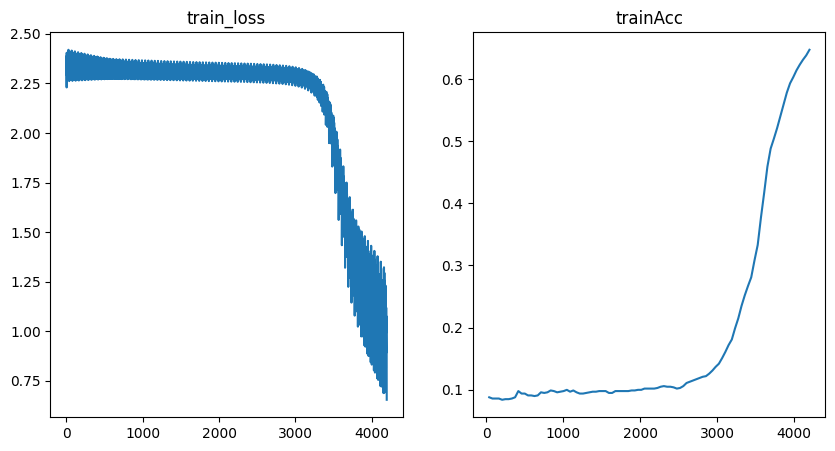

In [3]:
from importlib import reload
import posteriors.sgld as sgld
reload(sgld)

sgldnet = sgld.sgld(net=net, loss_fn=torch.nn.CrossEntropyLoss(), 
               lr=1e-1, wd=1e-4, nf=1e-4, 
               epochs=100)
sgldnet.train(training_data, test_data, val_data, batch_size=25, plot_loss=True)

In [ ]:
reload(sgld)
device = 'cpu'

testloader = DataLoader(test_data,25)

preds = []
for x,_ in testloader:
    preds.append(sgldnet.eval(x))
preds = torch.cat(preds,-1)
print(preds.shape)

logits = evaluate_batch(test_data, lambda x : sgldnet.eval(x), 25)
logits.shape

torch.Size([25, 10, 800])


NameError: name 'evaluate_batch' is not defined

In [71]:
sgldnet.device

AttributeError: 'sgld' object has no attribute 'device'

In [13]:
from lightning_uq_box.uq_methods import sgld
from lightning import Trainer
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.viz_utils import (
    plot_training_metrics,
)
import tempfile
from lightning import LightningDataModule
import os

In [39]:
sgldmodel = sgld.SGLDClassification(model=net,
                                    loss_fn=torch.nn.CrossEntropyLoss(),
                                    lr=1e-1,
                                    weight_decay=1e-4,
                                    noise_factor=1e-4)

my_temp_dir = tempfile.mkdtemp()

logger = CSVLogger(my_temp_dir)

trainer = Trainer(
    max_epochs=300,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=True,
    default_root_dir=my_temp_dir,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [37]:
def collate_fn_tensordataset(batch):
    """Collate function for tensor dataset to our framework."""
    inputs = torch.stack([item[0] for item in batch])
    targets = torch.stack([torch.tensor(item[1]) for item in batch])
    return {"input": inputs, "target": targets}

class LightningDataset(LightningDataModule):

    def __init__(
        self,
        train,
        test,
        val,
        train_bs,
        test_bs,
        val_bs
    ) -> None:
        """Initialize a new Toy Data Module instance.
        """
        super().__init__()

        self.train = train
        self.test = test
        self.val = val
        self.train_bs = train_bs
        self.test_bs = test_bs
        self.val_bs = val_bs

    def train_dataloader(self) -> DataLoader:
        """Return train dataloader."""
        return DataLoader(self.train,self.train_bs, collate_fn=collate_fn_tensordataset)

    def val_dataloader(self) -> DataLoader:
        """Return val dataloader."""
        return DataLoader(self.test,self.test_bs, collate_fn=collate_fn_tensordataset)

    def test_dataloader(self) -> DataLoader:
        """Return test dataloader."""
        return DataLoader(self.val,self.val_bs, collate_fn=collate_fn_tensordataset)

lightningdata = LightningDataset(train=training_data,
                    test=test_data,
                    val=val_data,
                    train_bs=25,
                    test_bs=25,
                    val_bs=25
)


  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | LeNet5           | 61.7 K | train
1 | loss_fn       | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=300` reached.


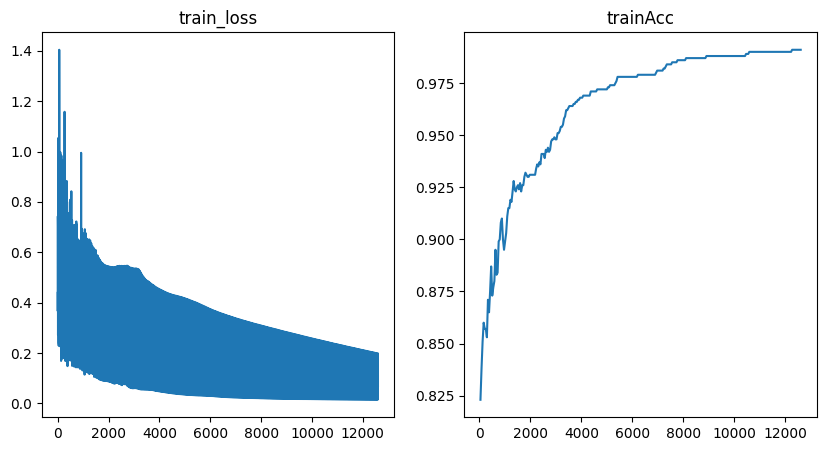

In [58]:
trainer.fit(sgldmodel, lightningdata)
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainAcc"]
)
fig.savefig(os.path.join(my_temp_dir, "lightning_logs.pdf"), format='pdf')

In [47]:
sgldmodel.predict_step(x)['logits'].shape

torch.Size([25, 10, 20])

In [46]:
testloader = DataLoader(test_data,25)

# for x,y in testloader:
#     print(sgldmodel.predict_step(x))
#     break

size = len(test_data)
num_batches = len(testloader)
test_loss, correct = 0, 0
loss_fn = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for x, y in testloader:
        pred = sgldmodel.predict_step(x)['pred']
        test_loss += loss_fn(pred,y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

test_loss /= num_batches
correct /= size

print(f'test loss: {test_loss:.3}, acc: {correct:.1%}')

test loss: 1.78, acc: 70.4%


# Bayesian Deep Ensemble Testing

In [20]:
import posteriors.bde as BDE
from importlib import reload
reload(BDE)

net = model.LeNet5()
bde_net = BDE.bde(net)

trainloader = DataLoader(training_data, 25)
testloader = DataLoader(test_data, 25)

optimizer = torch.optim.Adam(bde_net.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

BDE.training_classification(net=bde_net,
                            trainloader=trainloader,
                            testloader=testloader,
                            epochs=100,
                            optimizer=optimizer,
                            scheduler=scheduler,
                            num_classes=10,
                            verbose=True)

| Epoch [ 54/100] Loss: 0.00052399 Acc@1: 99.700% Test Loss: 0.01255209 Test Acc@1: 91.900%

KeyboardInterrupt: 

In [228]:
net1 = model.LeNet5()
net1.apply(init_weights_he)

net2 = model.LeNet5()
net2.apply(init_weights_he)

bde_net = BDE(net1, net2, num_class=n_output)

bde_net.training(training_data, bs=100, epochs=100, verbose=True)
bde_net.val_acc(val_data, 100)

BDE is using device cpu.


C:\Users\s4531973\AppData\Local\Temp\ipykernel_9364\93323086.py:123: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = self.loss_fn(y_onehot, torch.nn.functional.softmax(pred))


epoch: 0, train loss: 0.093, train acc: 9.6%
epoch: 1, train loss: 0.091, train acc: 10.4%
epoch: 2, train loss: 0.090, train acc: 12.6%
epoch: 3, train loss: 0.089, train acc: 15.2%
epoch: 4, train loss: 0.088, train acc: 17.9%
epoch: 5, train loss: 0.086, train acc: 26.0%
epoch: 6, train loss: 0.083, train acc: 24.9%
epoch: 7, train loss: 0.081, train acc: 28.2%
epoch: 8, train loss: 0.079, train acc: 30.5%
epoch: 9, train loss: 0.079, train acc: 30.7%
epoch: 10, train loss: 0.079, train acc: 30.9%
epoch: 11, train loss: 0.079, train acc: 31.6%
epoch: 12, train loss: 0.078, train acc: 32.3%
epoch: 13, train loss: 0.076, train acc: 35.1%
epoch: 14, train loss: 0.071, train acc: 40.4%
epoch: 15, train loss: 0.065, train acc: 48.7%
epoch: 16, train loss: 0.055, train acc: 59.5%
epoch: 17, train loss: 0.044, train acc: 68.3%
epoch: 18, train loss: 0.039, train acc: 71.0%
epoch: 19, train loss: 0.035, train acc: 75.9%
epoch: 20, train loss: 0.030, train acc: 79.8%
epoch: 21, train loss: 0

0.086

In [137]:
y

tensor([1, 6, 0, 9, 5])

In [196]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, train_mode=True):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    if train_mode:
        model.train()
    else:
        model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)    
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X,y = X, y
        # Compute prediction and loss
        pred = torch.nn.functional.softmax(model(X), dim=-1)
        # pred = model(X)
        loss = loss_fn(pred, torch.nn.functional.one_hot(y,num_classes=10).to(dtype=torch.float64))
        # loss = loss_fn(pred,y)
        # loss = torch.mean((pred - torch.nn.functional.one_hot(y,num_classes=10).to(dtype=torch.float64))**2)
        # print(pred[0],
        #       torch.nn.functional.one_hot(y,num_classes=10).to(dtype=torch.float64)[0])

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Evaluate metrics
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    if scheduler is not None:
        scheduler.step()

    train_loss /= num_batches
    correct /= size

    return train_loss, correct


def test_loop(dataloader, model, loss_fn, verbose=False):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X, y
            pred = model(X)
            test_loss += loss_fn(pred, torch.nn.functional.one_hot(y,num_classes=10).to(dtype=torch.float64)).item()
            # test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    return test_loss, correct

def training(train_loader, test_loader, model, loss_fn, optimizer, scheduler = None, epochs: int = 50, verbose: bool = False, progress_bar = True, train_mode = True):
    '''
    Training function. Will train and test, and will report metrics.

    Outputs:
        - train_loss
        - train_acc
        - test_loss
        - test_acc
    '''
    
    if progress_bar:
        pbar = tqdm.trange(epochs)
    else:
        pbar = range(epochs)

    for epoch in pbar:
        train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer, scheduler, train_mode=train_mode)
        test_loss, test_acc = test_loop(test_loader, model, loss_fn)
        if verbose:
            if epoch % 1 == 0:
                print("Epoch {} of {}".format(epoch,epochs))
                print("Training loss = {:.6f}".format(train_loss))
                print("Train accuracy = {:.1f}%".format(100*train_acc))
                print("Test loss = {:.4f}".format(test_loss))
                print("Test accuracy = {:.1f}%".format(100*test_acc))
                print("\n -------------------------------------")
    if verbose:
        print("Done!")
        print("Final training loss = {:.4f}".format(train_loss))
        print("Final train accuracy = {:.1f}%".format(100*train_acc))
        print("Final test loss = {:.4f}".format(test_loss))
        print("Final test accuracy = {:.1f}%".format(100*test_acc))
    return train_loss, train_acc, test_loss, test_acc

In [202]:
from functorch import make_functional, make_functional_with_buffers
from torch.func import functional_call, vmap, jacrev, jvp
import utils.training

def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

net1 = model.LeNet5()
# net1 = torch.nn.Sequential(net1, torch.nn.Softmax())
# fnet, params = make_functional(net1)

train_loader = DataLoader(training_data,5)
net1.apply(init_weights)

## Compute jacobian of net, evaluated on training set
def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)

for x,y in train_loader:
    # J = vmap(jacrev(fnet_single), (None, 0))(params, x)
    # J = [j.detach().flatten(2) for j in J]
    # J = torch.cat(J,dim=2).detach()
    # print(J @ torch.ones(J.shape[2]))
    print(net1(x)[0])

optimizer = torch.optim.Adam(net1.parameters(), lr=1e-2, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 100)

train_dataloader = DataLoader(training_data, batch_size=25, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=25)
ood_test_dataloader = DataLoader(ood_test_data, batch_size=25)

train_loss, train_acc, _, _ = training(train_loader=train_dataloader,test_loader=test_dataloader,
                                                        model=net1, loss_fn=torch.nn.MSELoss(), optimizer=optimizer,
                                                        scheduler=scheduler,epochs=200,
                                                        verbose=True, progress_bar=True)

tensor([ 0.3484, -0.0042, -0.4259, -1.8038, -0.7360,  0.7827, -0.7726, -1.9198,
         0.8409,  1.6754], grad_fn=<SelectBackward0>)
tensor([ 0.3483, -0.0036, -0.4256, -1.8029, -0.7362,  0.7824, -0.7734, -1.9200,
         0.8406,  1.6754], grad_fn=<SelectBackward0>)
tensor([ 0.3480, -0.0043, -0.4256, -1.8031, -0.7359,  0.7834, -0.7725, -1.9203,
         0.8401,  1.6763], grad_fn=<SelectBackward0>)
tensor([ 0.3494, -0.0039, -0.4256, -1.8037, -0.7374,  0.7831, -0.7731, -1.9212,
         0.8410,  1.6765], grad_fn=<SelectBackward0>)
tensor([ 0.3489, -0.0035, -0.4255, -1.8035, -0.7367,  0.7830, -0.7727, -1.9202,
         0.8413,  1.6756], grad_fn=<SelectBackward0>)
tensor([ 0.3496, -0.0035, -0.4256, -1.8032, -0.7368,  0.7827, -0.7745, -1.9209,
         0.8410,  1.6755], grad_fn=<SelectBackward0>)
tensor([ 0.3493, -0.0043, -0.4260, -1.8039, -0.7361,  0.7831, -0.7732, -1.9199,
         0.8407,  1.6755], grad_fn=<SelectBackward0>)
tensor([ 0.3493, -0.0044, -0.4256, -1.8036, -0.7368,  0.7830, 

  0%|          | 1/200 [00:00<01:14,  2.69it/s]

Epoch 0 of 200
Training loss = 0.091392
Train accuracy = 11.4%
Test loss = 0.2206
Test accuracy = 11.6%

 -------------------------------------


  1%|          | 2/200 [00:00<01:15,  2.63it/s]

Epoch 1 of 200
Training loss = 0.090451
Train accuracy = 10.8%
Test loss = 0.2026
Test accuracy = 11.6%

 -------------------------------------


  2%|▏         | 3/200 [00:01<01:13,  2.68it/s]

Epoch 2 of 200
Training loss = 0.090406
Train accuracy = 9.9%
Test loss = 0.1591
Test accuracy = 8.7%

 -------------------------------------


  2%|▏         | 4/200 [00:01<01:13,  2.65it/s]

Epoch 3 of 200
Training loss = 0.090381
Train accuracy = 10.4%
Test loss = 0.1602
Test accuracy = 8.7%

 -------------------------------------


  2%|▎         | 5/200 [00:01<01:12,  2.68it/s]

Epoch 4 of 200
Training loss = 0.090307
Train accuracy = 10.5%
Test loss = 0.1781
Test accuracy = 11.6%

 -------------------------------------


  3%|▎         | 6/200 [00:02<01:12,  2.69it/s]

Epoch 5 of 200
Training loss = 0.090192
Train accuracy = 12.2%
Test loss = 0.1721
Test accuracy = 11.6%

 -------------------------------------


  4%|▎         | 7/200 [00:02<01:11,  2.70it/s]

Epoch 6 of 200
Training loss = 0.089791
Train accuracy = 13.7%
Test loss = 0.1891
Test accuracy = 12.6%

 -------------------------------------


  4%|▍         | 8/200 [00:02<01:11,  2.69it/s]

Epoch 7 of 200
Training loss = 0.085784
Train accuracy = 22.6%
Test loss = 0.4513
Test accuracy = 11.6%

 -------------------------------------


  4%|▍         | 9/200 [00:03<01:11,  2.68it/s]

Epoch 8 of 200
Training loss = 0.081784
Train accuracy = 25.1%
Test loss = 0.5197
Test accuracy = 35.7%

 -------------------------------------


  5%|▌         | 10/200 [00:03<01:11,  2.66it/s]

Epoch 9 of 200
Training loss = 0.065346
Train accuracy = 46.9%
Test loss = 1.7886
Test accuracy = 52.6%

 -------------------------------------


  6%|▌         | 11/200 [00:04<01:11,  2.65it/s]

Epoch 10 of 200
Training loss = 0.050856
Train accuracy = 62.3%
Test loss = 3.6488
Test accuracy = 63.5%

 -------------------------------------


  6%|▌         | 12/200 [00:04<01:10,  2.66it/s]

Epoch 11 of 200
Training loss = 0.041309
Train accuracy = 69.6%
Test loss = 5.1923
Test accuracy = 71.2%

 -------------------------------------


  6%|▋         | 13/200 [00:04<01:10,  2.65it/s]

Epoch 12 of 200
Training loss = 0.034612
Train accuracy = 76.2%
Test loss = 6.4919
Test accuracy = 73.5%

 -------------------------------------


  7%|▋         | 14/200 [00:05<01:10,  2.65it/s]

Epoch 13 of 200
Training loss = 0.031079
Train accuracy = 78.1%
Test loss = 6.8106
Test accuracy = 74.0%

 -------------------------------------


  8%|▊         | 15/200 [00:05<01:09,  2.65it/s]

Epoch 14 of 200
Training loss = 0.026926
Train accuracy = 81.9%
Test loss = 7.3403
Test accuracy = 72.3%

 -------------------------------------


  8%|▊         | 16/200 [00:05<01:08,  2.67it/s]

Epoch 15 of 200
Training loss = 0.022549
Train accuracy = 85.3%
Test loss = 7.9326
Test accuracy = 78.4%

 -------------------------------------


  8%|▊         | 17/200 [00:06<01:07,  2.73it/s]

Epoch 16 of 200
Training loss = 0.019153
Train accuracy = 87.2%
Test loss = 8.5202
Test accuracy = 82.3%

 -------------------------------------


  9%|▉         | 18/200 [00:06<01:07,  2.69it/s]

Epoch 17 of 200
Training loss = 0.015907
Train accuracy = 89.6%
Test loss = 9.1950
Test accuracy = 84.4%

 -------------------------------------


 10%|▉         | 19/200 [00:07<01:07,  2.70it/s]

Epoch 18 of 200
Training loss = 0.014264
Train accuracy = 90.3%
Test loss = 9.9017
Test accuracy = 84.5%

 -------------------------------------


 10%|█         | 20/200 [00:07<01:08,  2.64it/s]

Epoch 19 of 200
Training loss = 0.012603
Train accuracy = 92.7%
Test loss = 10.1802
Test accuracy = 83.5%

 -------------------------------------


KeyboardInterrupt: 

In [173]:
y = torch.tensor([0,0,1.00])
f = torch.tensor([0,0,1])

print(((y-f)**2).sum())

tensor(0.)


In [142]:
fnet, params = make_functional(net1)
def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)

for x,y in train_loader:
    J = vmap(jacrev(fnet_single), (None, 0))(params, x)
    J = [j.detach().flatten(2) for j in J]
    J = torch.cat(J,dim=2).detach()
    print(J @ torch.ones(J.shape[2]))
    # print(net1(x)[0])

C:\Users\s4531973\AppData\Local\Temp\ipykernel_9364\4215352118.py:1: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(net1)


tensor([[ 76.7162,  -2.3730,  69.8351,  68.5401, -14.1915,  10.5416,  16.8843,
           6.3725,  -8.6145,   2.6083],
        [ 47.4645,  16.7111,  67.4154,  93.5666, -65.1054,  52.0155, -33.4714,
           0.4074,  69.1981,  24.0372],
        [ 28.0583,  47.9824,   4.9106,   5.5613,  28.7574,  69.4138,  31.0685,
          29.3055,  46.5479,  18.0655],
        [ 67.8749,  20.9157,  60.6927,  29.6994,   3.1215,  42.8936,  79.8706,
          -4.9702,  62.1340,  21.0384],
        [ 60.2286,   4.2905,  91.1686,  31.4498,   6.0092,  -5.7280,  42.8357,
          56.2637, -24.3561,  41.2191]])
tensor([[ 47.9417,  25.3648,  22.8199,  32.6223,  40.6051,  64.8996,  55.4303,
          -1.2458,  52.0356,  46.5888],
        [ 42.8597,  30.2035,  80.4486, 122.7521,  16.0473,  19.7008,  13.8459,
          46.3685,  12.9896,  36.4749],
        [ 75.0486,   0.5256,  39.4448,  63.2889,  73.5969,  57.3963,  54.5827,
           4.2433,  24.6246,  64.7631],
        [ 37.1955,   4.5380,  45.6226,  88.0297

In [14]:
import torch

m = 1
C = 3
n = 4
a = torch.ones((n,n))*m
for i in range(n):
    a[i,i] = C
print(torch.linalg.eigvals(a))
print(torch.linalg.det(a))
print((C-m)**(n-1)*(C+m*(n-1)))
print(C-m)
print(C+m*(n-1))

tensor([2.+0.j, 6.+0.j, 2.+0.j, 2.+0.j])
tensor(48.)
48
2
6


In [16]:
a = torch.tensor([1,1,1,0,0,0,0])
print(a.roll(3))

tensor([0, 0, 0, 1, 1, 1, 0])


In [41]:
a = torch.tensor([1,1,0,0,0,1,0])
n = 7
A = torch.empty((n,n))

for i in range(n):
    A[i,:] = a.roll(i)

print(A.T @ A)
print(torch.linalg.det(A))

tensor([[3., 1., 1., 1., 1., 1., 1.],
        [1., 3., 1., 1., 1., 1., 1.],
        [1., 1., 3., 1., 1., 1., 1.],
        [1., 1., 1., 3., 1., 1., 1.],
        [1., 1., 1., 1., 3., 1., 1.],
        [1., 1., 1., 1., 1., 3., 1.],
        [1., 1., 1., 1., 1., 1., 3.]])
tensor(24.)


In [38]:
a = torch.tensor([1,0,0,1,1,0,0])
n = 7
A = torch.empty((n,n))

for i in range(n):
    A[i,:] = a.roll(i)

print(A)

tensor([[1., 0., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 0., 0., 1.],
        [1., 1., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0., 0., 1.]])


In [39]:
print(A @ A.T)

tensor([[3., 1., 0., 2., 2., 0., 1.],
        [1., 3., 1., 0., 2., 2., 0.],
        [0., 1., 3., 1., 0., 2., 2.],
        [2., 0., 1., 3., 1., 0., 2.],
        [2., 2., 0., 1., 3., 1., 0.],
        [0., 2., 2., 0., 1., 3., 1.],
        [1., 0., 2., 2., 0., 1., 3.]])


In [3]:
print(a)

tensor([[3., 1., 1., 1.],
        [1., 3., 1., 1.],
        [1., 1., 3., 1.],
        [1., 1., 1., 3.]])


In [20]:
import torch
import posteriors
from posteriors.batch_ensemble.wide_resnet_batchensemble import Wide_ResNet_BatchEnsemble

n = 1

net = Wide_ResNet_BatchEnsemble(6*n+4,1,0,10,10)

num_weights = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"num weights = {num_weights}")

| Wide-Resnet 10x1
num weights = 85366


In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
from networks.batchensemble_layers import *

import sys
import numpy as np

def conv3x3(in_planes, out_planes, stride=1,first_layer=False,num_models=4):
    return Ensemble_Conv2d(in_planes, out_planes, 3, stride=stride, padding=1, first_layer=first_layer, num_models=num_models)


def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            init.xavier_uniform_(m.conv.conv.weight, gain=np.sqrt(2))
        except:
            init.xavier_uniform_(m.weight, gain=np.sqrt(2))
            #init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

class wide_basic_ensemble(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1,num_models=4):
        super(wide_basic_ensemble, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        #self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.conv1 = Ensemble_Conv2d(in_planes, planes, 3, stride=1, padding=1, first_layer=False, num_models=num_models, bias=True)
        ##self.conv1 = Ensemble_Conv2dBatchNorm_pre(in_planes, planes, 3, stride=1, padding=1, first_layer=False, num_models=num_models, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        #self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)
        self.conv2 = Ensemble_Conv2d(planes, planes, 3, stride=stride, padding=1, first_layer=False, num_models=num_models, bias=True)
        ##self.conv2 = Ensemble_Conv2dBatchNorm_pre(planes, planes, 3, stride=stride, padding=1, first_layer=False, num_models=num_models, bias=True)
        self.num_models=num_models
        self.convs=[self.conv1,self.conv2]
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
                #Ensemble_Conv2d(in_planes, planes, 1, stride=stride, padding=0, first_layer=False, num_models=num_models, bias=True),
            )
    def update_indices(self, indices):
        for m_conv in self.convs:
            m_conv.update_indices(indices)

    def forward(self, x):
        curr_bs = x.size(0)
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class wide_basic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1,num_models=1):
        super(wide_basic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Wide_ResNet_BatchEnsemble(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes,num_models):
        super(Wide_ResNet_BatchEnsemble, self).__init__()
        self.in_planes = 16
        self.num_models = num_models
        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        print('| Wide-Resnet %dx%d' %(depth, k))
        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1,first_layer=True, num_models=num_models)
        self.layer1 = self._wide_layer(wide_basic_ensemble, nStages[1], n, dropout_rate, stride=1,num_models=num_models)
        self.layer2 = self._wide_layer(wide_basic_ensemble, nStages[2], n, dropout_rate, stride=2,num_models=num_models)
        self.layer3 = self._wide_layer(wide_basic_ensemble, nStages[3], n, dropout_rate, stride=2,num_models=num_models)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        #self.linear = nn.Linear(nStages[3], num_classes)
        self.linear =Ensemble_orderFC(nStages[3], num_classes, num_models, False)
        self.num_classes = num_classes
    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride,num_models):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride,num_models))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        if not self.training:
            out=F.softmax(out, dim=1)
            return out.view([self.num_models, -1, self.num_classes]).mean(dim=0)

        return out

In [1]:
import tensorflow as tf
import tf_keras as k3
# resnet50 = keras.layers.TFSMLayer(r"C:\Users\s4531973\Downloads\keras_model_step_63_0", call_endpoint='serving_default') 

resnet50 = k3.models.load_model(r"C:\Users\s4531973\Downloads\keras_model_step_63_0")

# resnet50 = tf.keras.layers.TFSMLayer(r'C:\Users\s4531973\Downloads\keras_model_step_63_0', call_endpoint='serving_default')

In [4]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1 (Conv2D)              (None, 256, 256, 64)         9408      ['conv1_pad[0][0]']           
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1[0][0]']               
 on)                                                                                       

In [3]:
!pip install tf2onnx
!pip install onnx2pytorch

  Using cached tf2onnx-1.16.1-py3-none-any.whl.metadata (1.3 kB)
INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
Using cached tf2onnx-1.16.1-py3-none-any.whl (455 kB)
   ---------------------------------------- 0.0/14.5 MB ? eta -:--:--
   -- ------------------------------------- 1.0/14.5 MB ? eta -:--:--
   ----- ---------------------------------- 2.1/14.5 MB 7.8 MB/s eta 0:00:02
   -------- ------------------------------- 3.1/14.5 MB 6.1 MB/s eta 0:00:02
   ----------- ---------------------------- 4.2/14.5 MB 5.7 MB/s eta 0:00:02
   -------------- ------------------------- 5.2/14.5 MB 5.2 MB/s eta 0:00:02
   --------------- ------------------------ 5.8/14.5 MB 4.6 MB/s eta 0:00:02
   ----------------- ---------------------- 6.3/14.5 MB 5.0 MB/s eta 0:00:02
   ----------------- ---------------------- 6.3/14.5 MB 5.0 MB/s eta 0:00:02
   -------------------- ------------------- 7.3/14.5 MB 4.1 M

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.16.1 requires ml-dtypes~=0.3.1, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow-metadata 1.15.0 requires protobuf<5,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Users\s4531973\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached onnx2pytorch-0.5.1-py3-none-any.whl.metadata (3.8 kB)
Using cached onnx2pytorch-0.5.1-py3-none-any.whl (46 kB)



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Users\s4531973\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import tf2onnx

onnx_model, _ = tf2onnx.convert.from_keras(resnet50)

import onnx
from onnx2pytorch import ConvertModel

# Convert ONNX model to PyTorch
pytorch_model = ConvertModel(onnx_model)
pytorch_model 


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x0000027C05C61300>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\onnx2pytorch\convert\layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


ConvertModel(
  (Transpose_resnet50/conv1/Conv2D__6:0): Transpose()
  (Conv_resnet50/bn_conv1/FusedBatchNormV3:0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (Relu_resnet50/activation/Relu:0): ReLU(inplace=True)
  (MaxPool_resnet50/max_pooling2d/MaxPool:0): Sequential(
    (0): ConstantPad2d(padding=(0, 1, 0, 1), value=0)
    (1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Conv_resnet50/bn2a_branch2a/FusedBatchNormV3:0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (Relu_resnet50/activation_1/Relu:0): ReLU(inplace=True)
  (Conv_resnet50/bn2a_branch2b/FusedBatchNormV3:0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Relu_resnet50/activation_2/Relu:0): ReLU(inplace=True)
  (Conv_resnet50/bn2a_branch2c/FusedBatchNormV3:0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (Conv_resnet50/bn2a_branch1/FusedBatchNormV3:0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (Add_resnet

In [10]:
import pandas as pd
df = pd.read_csv(r"C:\Users\s4531973\Downloads\trainLabels.csv\trainLabels.csv")
print(df.columns)
print(df['image'][800])

Index(['image', 'level'], dtype='object')
979_left


In [1]:
!pip list
import pandas as pd

Package                      Version
---------------------------- --------------------
absl-py                      1.4.0
annotated-types              0.7.0
anyio                        3.7.1
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asdfghjkl                    0.1a2
asdl                         0.1
astor                        0.8.1
asttokens                    2.2.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
backpack-for-pytorch         1.6.0
bayesian-ntk                 0.0.1
bayesian-torch               0.5.0
beautifulsoup4               4.12.2
bleach                       6.0.0
cachetools                   5.3.1
certifi                      2023.7.22
cffi                         1.15.1
charset-normalizer           3.2.0
chex                         0.1.88
click                        

In [2]:
import torch
import pandas as pd
import os
import PIL

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, img_dir, transform=None, 
target_transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.df['level'][idx]
        img_path = os.path.join(self.img_dir, self.df['image'][idx])
        image = PIL.Image.open(os.path.join(self.img_dir, img_path))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

ImportError: DLL load failed while importing _C: The specified module could not be found.

In [8]:
for p in pytorch_model.parameters():
    print(p.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64, 64, 1, 1])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([512, 128, 1, 1])
torch.Size([512])
torch.Size([512, 256, 1, 1])
torch.Size([512])
torch.Size([128, 512, 1, 1])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([512, 128, 1, 1])
torch.Size([512])
torch.Size([128, 512, 1, 1])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([512, 128, 1, 1])
torch.Size([512])
torch.Size([128, 512, 1, 1])
torch.Si

In [24]:
p = 0
for v in resnet50.variables:
    p += v.shape.sum()
print(p)

AttributeError: 'TensorShape' object has no attribute 'sum'

In [54]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

test_transform = transforms.Compose(
    [transforms.Resize(256), transforms.CenterCrop(256), transforms.ToTensor(), transforms.Normalize(mean, std)])

ood_data = datasets.ImageFolder(r'data\imagenet-o\imagenet-o', transform=test_transform)
ood_dataloader = DataLoader(ood_data, batch_size=20)
for x,y in ood_dataloader:
    print(x.shape)
    print(y)
    break


torch.Size([20, 3, 256, 256])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])


In [45]:
import torch
nuqls_weights = torch.load('models/nuqls_lenet_mnist.pt', map_location=torch.device('cpu'))
l = list(nuqls_weights['training'].keys())[-1]
nuqls_weights['training'][l]['weights']

tensor([[ 2.9364,  2.5759,  1.9887,  ...,  0.9884,  1.8137, -0.1479],
        [ 0.2279,  1.3989,  0.9616,  ...,  3.5944,  0.8089, -0.8947],
        [ 1.6834,  0.1860,  3.6663,  ..., -0.0287,  3.8938,  2.6769],
        ...,
        [-1.4764, -0.6021, -1.7260,  ...,  0.2764,  0.4213,  3.1592],
        [-0.3247,  0.6335,  0.0485,  ...,  0.8071,  1.1060,  0.9686],
        [ 0.7279, -1.6480, -1.5778,  ..., -0.2599, -0.1986,  0.6641]],
       dtype=torch.float64)

In [41]:
l = ['1', '20', '15']
l.sort()
print(l)

['1', '15', '20']


In [ ]:
l = list(nuqls_weights['training'].keys()).sort()


In [2]:
from colorspacious import cspace_converter

import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl

In [3]:
50000*10*840*8 / 10**9


3.36

In [25]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
        root="data/MNIST",
        train=True,
        download=True,
        transform=ToTensor()
    )

def dataset_with_indices(cls):
    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index

    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })
        
MNISTWithIndices = dataset_with_indices(datasets.MNIST)
dataset = MNISTWithIndices(
        root="data/MNIST",
        train=True,
        download=True,
        transform=ToTensor()
    )

train_loader = DataLoader(dataset, 10, shuffle=True)

for x,y,idx in train_loader:
    print(idx)

tensor([ 3756, 23094,  3613, 28802, 52838, 36710, 11182,  2414, 47640, 25757])
tensor([25163, 11169, 25247, 56463, 16431, 36609, 49963,  4133, 45840, 32489])
tensor([31469, 33279, 34739, 33526,  7069,  9139,   669, 14154,  3084,  9753])
tensor([57102, 48538, 30008,  9585, 35993, 44085, 25311, 35664, 34967, 45547])
tensor([58010, 34758, 55506, 57675, 15060, 38242, 30256, 59574, 33626, 26098])
tensor([37632, 14365, 51566, 32083, 20829, 38312, 47416, 37338, 31069,  7215])
tensor([35843, 12911, 20702, 19260, 49511, 39380, 20464, 30930,  2358,  3563])
tensor([  569,  8938, 20315, 19631, 49528,  4524, 14068, 26111, 11712,  7331])
tensor([15928,  1171, 46329, 36161, 29327, 42388, 40853, 54526, 43412, 39037])
tensor([32658, 33055,  7234, 48406, 15888, 35745,  7627, 48757, 52329, 13718])
tensor([20272, 15675, 51619, 40657,  3880, 57752,   852,  8419, 41856, 12712])
tensor([25826, 57177, 40968, 31050, 31075, 58433, 36783, 13914, 18458, 42684])
tensor([55867, 53202, 40921, 21024, 39584, 55171,  1

In [14]:
X.permute(1,0).reshape(-1)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109])

In [10]:
import torch

p = 10
c = 11

a = torch.arange(0,p)
b = torch.arange(0,p*c)

print(a)
print(b)

X = b.reshape(c, p).T
print(X)

Jx = a @ X
print(Jx)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109])
tensor([[  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100],
        [  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101],
        [  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102],
        [  3,  13,  23,  33,  43,  53,  63,  73,  83,  93, 103],
        [  4,  14,  24,  34,  44,  54,  64,  74,  84,  94, 104],
        [  5,  15,  2

In [26]:
150*100*2000*1000*8/10**9

240.0

In [3]:
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=mpl.colormaps[name])
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

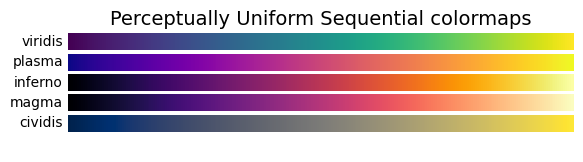

In [4]:
plot_color_gradients('Perceptually Uniform Sequential',
                     ['viridis', 'plasma', 'inferno', 'magma', 'cividis'])

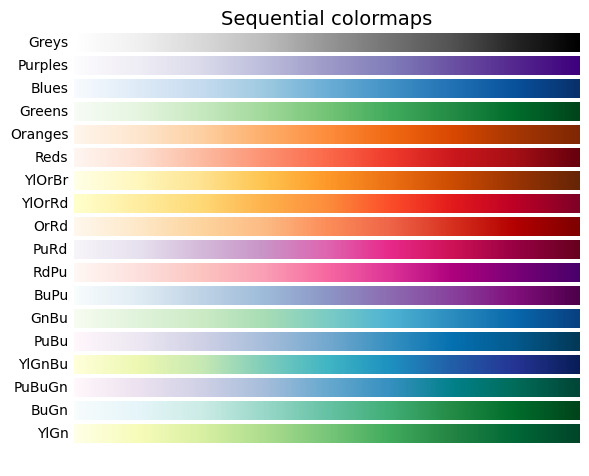

In [5]:
plot_color_gradients('Sequential',
                     ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'])

In [1]:
import torch

train_res = torch.load('train_res_example.pt')
test_res = torch.load('test_res_example.pt')

print(train_res)
print(test_res)

{'MAP': {'nll': [0.5033256976978755], 'acc': [0.844]}, 'NUQLS': {'nll': [0.5730941971918087], 'acc': [0.815]}}
{'MAP': {'nll': [0.5259737083013409], 'acc': [0.8299999833106995], 'ece': [0.09929487109184265], 'oodauc': [0.7438], 'aucroc': [0.7494], 'varroc': [], 'time': [6.819732427597046], 'mem': [0.0]}, 'NUQLS': {'nll': [0.5293368816084257], 'acc': [0.8100000023841858], 'ece': [0.06496739387512207], 'oodauc': [0.7474], 'aucroc': [0.7633], 'varroc': [0.36929999999999996], 'time': [18.54954981803894], 'mem': [0.0]}, 'SWAG': {'nll': [0.4450936320867767], 'acc': [0.8399999737739563], 'ece': [0.08057935535907745], 'oodauc': [0.7572], 'aucroc': [0.7543000000000001], 'varroc': [0.36929999999999996], 'time': [8.131224632263184], 'mem': [0.0]}}


In [5]:
import configparser

#--- Get hyperparameters from config file
config = configparser.ConfigParser()
config.read('utils/classification.ini')
field = f"{'lenet'}_{'mnist'}"
n_experiment = config.getint(field,'n_experiment')
epochs = config.getint(field,'epochs')
lr = config.getfloat(field,'lr')
wd = config.getfloat(field,'wd')
bs = config.getint(field,'bs')
S = config.getint(field,'S')
nuqls_S = config.getint(field,'nuqls_S')
nuqls_epoch = config.getint(field,'nuqls_epoch')
nuqls_lr = config.getfloat(field,'nuqls_lr')
nuqls_wd = config.getfloat(field,'nuqls_wd')
nuqls_bs = config.getint(field,'nuqls_bs')
nuqls_gamma = config.getfloat(field,'nuqls_gamma')
nuqls_parallel = config.getboolean(field,'nuqls_parallel')
print(f'nuqls_parallel = {nuqls_parallel}')
# ---

nuqls_parallel = True


In [8]:
res_text = f"result.txt"
results = open(res_text,'w')

percentage_metrics = ['acc','ece','oodauc','aucroc','varroc']
methods = ['MAP','NUQLS','SWAG']
import time
import numpy as np
n_experiment = 1

results.write("Training Details:\n")
results.write(f'MAP/DE: epochs: {epochs}; S: {S}; lr: {lr}; wd: {wd}; bs: {bs}; n_experiment: {n_experiment}\n')
results.write(f"NUQLS: epochs: {nuqls_epoch}; S: {nuqls_S}; lr: {nuqls_lr}; wd: {nuqls_wd}; bs: {nuqls_bs}; gamma: {nuqls_gamma}\n")

if n_experiment > 1:
    results.write("\nTrain Results:\n")
    for m in train_res.keys():
        results.write(f"{m}: ")
        for k in train_res[m].keys():
            results.write(f"{k}: {np.mean(train_res[m][k]):.4} +- {np.std(train_res[m][k]):.4}; ")
        results.write('\n')
    results.write("\nTest Prediction:\n")
    for m in test_res.keys():
        results.write(f"{m}: ")
        for k in test_res[m].keys():
            if k == 'varroc' and m == 'MAP':
                continue
            results.write(f"{k}: {np.mean(test_res[m][k]):.4} +- {np.std(test_res[m][k]):.4}; ")
        results.write('\n')
else:
    results.write("\nTrain Results:\n")
    for m in train_res.keys():
        results.write(f"{m}: ")
        for k in train_res[m].keys():
            results.write(f"{k}: {train_res[m][k][0]:.4}; ")
        results.write('\n')
    results.write("\nTest Prediction:\n")
    for m in test_res.keys():
        results.write(f"{m}: ")
        for k in test_res[m].keys():
            if k == 'varroc' and m == 'MAP':
                continue
            results.write(f"{k}: {test_res[m][k][0]:.4}; ")
        results.write('\n')

results.close()

In [11]:
import torch
from torchvision.transforms import ToTensor

train = torchvision.datasets.SVHN(root='./data/SVHN',
                          split='train',
                          download=True,
                          transform=ToTensor())

ood_test_data = torchvision.datasets.CIFAR10(
        root="data/CIFAR10",
        train=False,
        download=True,
        transform=ToTensor()
    ) 

Using downloaded and verified file: ./data/SVHN\train_32x32.mat
Files already downloaded and verified


In [8]:
from utils.metrics import *
_,targets = next(iter(DataLoader(train,len(train))))
print(targets)

tensor([1, 9, 2,  ..., 1, 6, 9])


In [13]:
print(torch.tensor(ood_test_data.targets))

tensor([3, 8, 8,  ..., 5, 1, 7])


In [2]:
import torch
torch.manual_seed(0)
torch.randn(100)

tensor([-1.1258e+00, -1.1524e+00, -2.5058e-01, -4.3388e-01,  8.4871e-01,
         6.9201e-01, -3.1601e-01, -2.1152e+00,  3.2227e-01, -1.2633e+00,
         3.4998e-01,  3.0813e-01,  1.1984e-01,  1.2377e+00,  1.1168e+00,
        -2.4728e-01, -1.3527e+00, -1.6959e+00,  5.6665e-01,  7.9351e-01,
         5.9884e-01, -1.5551e+00, -3.4136e-01,  1.8530e+00,  7.5019e-01,
        -5.8550e-01, -1.7340e-01,  1.8348e-01,  1.3894e+00,  1.5863e+00,
         9.4630e-01, -8.4368e-01, -6.1358e-01,  3.1593e-02, -4.9268e-01,
         2.4841e-01,  4.3970e-01,  1.1241e-01,  6.4079e-01,  4.4116e-01,
        -1.0231e-01,  7.9244e-01, -2.8967e-01,  5.2507e-02,  5.2286e-01,
         2.3022e+00, -1.4689e+00, -1.5867e+00, -6.7309e-01,  8.7283e-01,
         1.0554e+00,  1.7784e-01, -2.3034e-01, -3.9175e-01,  5.4329e-01,
        -3.9516e-01, -4.4622e-01,  7.4402e-01,  1.5210e+00,  3.4105e+00,
        -1.5312e+00, -1.2341e+00,  1.8197e+00, -5.5153e-01, -5.6925e-01,
         9.1997e-01,  1.1108e+00,  1.2899e+00, -1.4

In [14]:

_,targets = next(iter(DataLoader(ood_test_data,len(ood_test_data))))
print(targets)

tensor([3, 8, 8,  ..., 5, 1, 7])


In [39]:
loader = torch.utils.data.DataLoader(train,len(train))
train_set,_ = next(iter(loader))

train_set.mean((0,2,3))

tensor([0.4377, 0.4438, 0.4728])

In [14]:
train = torchvision.datasets.CIFAR10(root='./data/CIFAR10',
                          train=True,
                          download=True,
                          transform=ToTensor())

100%|██████████| 170498071/170498071 [00:13<00:00, 12887125.91it/s]


Extracting ./data/CIFAR10\cifar-10-python.tar.gz to ./data/CIFAR10


In [25]:
loader = torch.utils.data.DataLoader(train,len(train))
train_set,_ = next(iter(loader))

In [3]:
import torch
dev = torch.device('cuda', 0)
print(dev.type)

cuda


In [1]:
from tqdm import tqdm, trange
from random import random, randint
from time import sleep

with trange(10) as t:
    for i in t:
        # Description will be displayed on the left
        t.set_description('GEN %i' % i)
        # Postfix will be displayed on the right,
        # formatted automatically based on argument's datatype
        metrics = {'loss': random(),
                   'gen': randint(1,999),
                   'str': 'h',
                   'lst': [1,2]}
        t.set_postfix(metrics)
        # t.set_postfix(loss=random(), gen=randint(1,999), str='h',
        #               lst=[1, 2])
        sleep(0.1)
        print(t.format_dict['n'])

with tqdm(total=10, bar_format="{postfix[0]} {postfix[1][value]:>8.2g}",
          postfix=["Batch", {"value": 0}]) as t:
    for i in range(10):
        sleep(0.1)
        t.postfix[1]["value"] = i / 2
        t.update()

GEN 2:  20%|██        | 2/10 [00:00<00:00,  9.61it/s, loss=0.187, gen=828, str=h, lst=[1, 2]]

0
1


GEN 4:  50%|█████     | 5/10 [00:00<00:00,  9.61it/s, loss=0.0167, gen=204, str=h, lst=[1, 2]]

2
3
4


GEN 7:  80%|████████  | 8/10 [00:00<00:00,  9.62it/s, loss=0.875, gen=418, str=h, lst=[1, 2]] 

5
6
7


GEN 9: 100%|██████████| 10/10 [00:01<00:00,  9.56it/s, loss=0.199, gen=309, str=h, lst=[1, 2]]


8
9


Batch      4.5


In [18]:
from tqdm import tqdm
class TqdmExtraFormat(tqdm):
    """Provides a `total_time` format parameter"""
    @property
    def format_dict(self):
        d = super().format_dict
        total_time = d["elapsed"] * (d["total"] or 0) / max(d["n"], 1)
        d.update(total_time=self.format_interval(total_time) + " in total")
        return d

for i in TqdmExtraFormat(
      range(9), ascii=" .oO0",
      bar_format="{total_time}: {percentage:.0f}%|{bar}{r_bar}"):
    if i == 4:
        break

00:00 in total: 44%|0000.     | 4/9 [00:00<?, ?it/s]


In [32]:
epochs = 500

t = range(500)

for ti in t:
    if ti % (epochs // 10) == 0:
        print(ti)

0
50
100
150
200
250
300
350
400
450


In [2]:
import torch
pvd = torch.load('pvd.pt')
print(pvd)

{'NUQLS': {'id_correct': tensor([1.2145e-01, 9.8095e-02, 1.9461e-01, 8.0672e-09, 4.5516e-05, 5.9706e-02,
        1.5932e-05, 7.1216e-07, 1.2357e-03, 1.4806e-08, 2.0080e-09, 8.5038e-10,
        1.5000e-02, 5.1327e-04, 1.1205e-08, 1.9641e-12, 4.1235e-07, 8.3172e-06,
        2.0097e-02, 3.0433e-05], dtype=torch.float64), 'id_incorrect': tensor([0.1985], dtype=torch.float64), 'ood': tensor([1.2145e-01, 9.8095e-02, 1.9461e-01, 8.0672e-09, 4.5516e-05, 5.9706e-02,
        1.5932e-05, 7.1216e-07, 1.2357e-03, 1.4806e-08, 2.0080e-09, 8.5038e-10,
        1.5000e-02, 5.1327e-04, 1.1205e-08, 1.9641e-12, 4.1235e-07, 8.3172e-06,
        2.0097e-02, 3.0433e-05], dtype=torch.float64)}, 'BASE': {'id_correct': tensor([0.0051, 0.0308, 0.0315], dtype=torch.float64), 'id_incorrect': tensor([0.1985], dtype=torch.float64), 'ood': tensor([0.0047, 0.0134, 0.0132, 0.0267, 0.0182, 0.0221, 0.0199, 0.0201, 0.0553,
        0.0142, 0.0108, 0.0346, 0.0238, 0.0086, 0.0162, 0.0157, 0.0161, 0.0299,
        0.0405, 0.0330

In [7]:
150+6+2400+16+48000+120+10080+84+840+10

61706